# En XGB modell för att estimera priset på en diamant

## 0. Importer
Först kommer alla importer som behövs för projektet

In [199]:
import matplotlib.pyplot as plt
import pandas as pd
import xgboost as xgb
from IPython.display import display
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

## 1. Förberedning av data
Vi börjar med att ladda in datasetet

In [200]:
df = pd.read_csv('diamonds.csv')

original_length = df.shape[0]

# Dubeltter och en kolumn med index
df.drop_duplicates(inplace=True)
df.drop('Unnamed: 0', axis='columns', inplace=True)

display(df.head())

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


## 1.1 Visualisering
Vi skapar några grafer för att visualisera datan

Här skapas en funktion som jämför varje kolumn med den diamantens pris. Vi kan hoppa över *cut*, *color* och *clarity* eftersom det är kategoriska

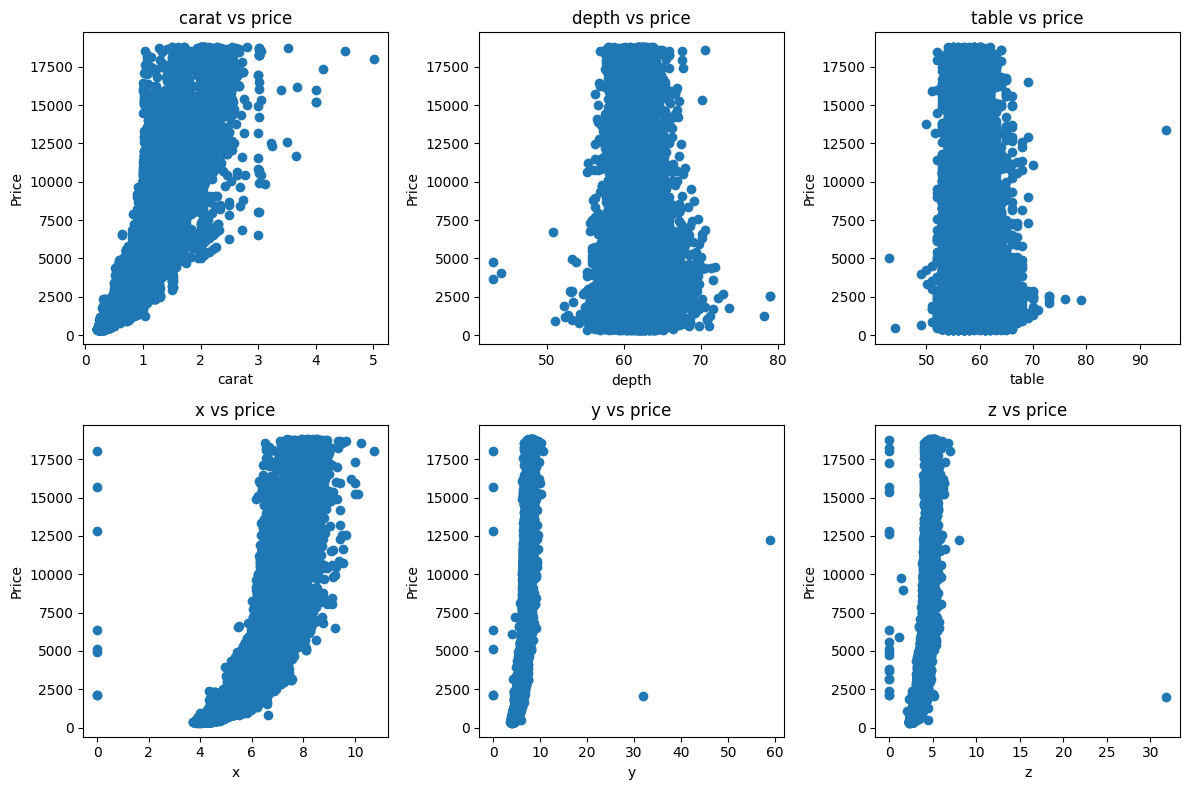

In [201]:
def plot_statistics():
    '''Rita en jämförelse mellan pris och alla andra kolumner'''

    plt.figure(figsize=(12, 8))
    for n, column in enumerate(df.drop(columns=['price', 'cut', 'color', 'clarity']).columns, 1):
        plt.subplot(2, 3, n)
        plt.scatter(df[column], df['price'])
        plt.xlabel(column)
        plt.ylabel('Price')
        plt.title(f'{column} vs price')

    plt.tight_layout()

plot_statistics()

## 1.2 Förbehandling

Vi ser att det på flera platser finns punkter som sticker ut mycket från resten av datan, och därför vill vi sortera bort dem.

Från grafen ser vi att några av diamanternas *y* eller *z* är noll. Det finns också några som har väldigt stora värden. En diamant som saknar en dimension, eller har en orimlig storlek är inte så bra att ta med i träningsdatan, så vi tar bort dem.

In [202]:
df.drop(df[df['y'] == 0].index, inplace=True)
df.drop(df[df['y'] > 20].index, inplace=True)

df.drop(df[df['z'] < 2].index, inplace=True)
df.drop(df[df['z'] > 20].index, inplace=True)

Även i kolumnerna *depth* och *table* så finns det värden som sticker ut mycket

In [203]:
df.drop(df[df['depth'] < 47.5].index, inplace=True)
df.drop(df[df['depth'] > 77.5].index, inplace=True)

df.drop(df[df['table'] < 40].index, inplace=True)
df.drop(df[df['table'] > 77.5].index, inplace=True)

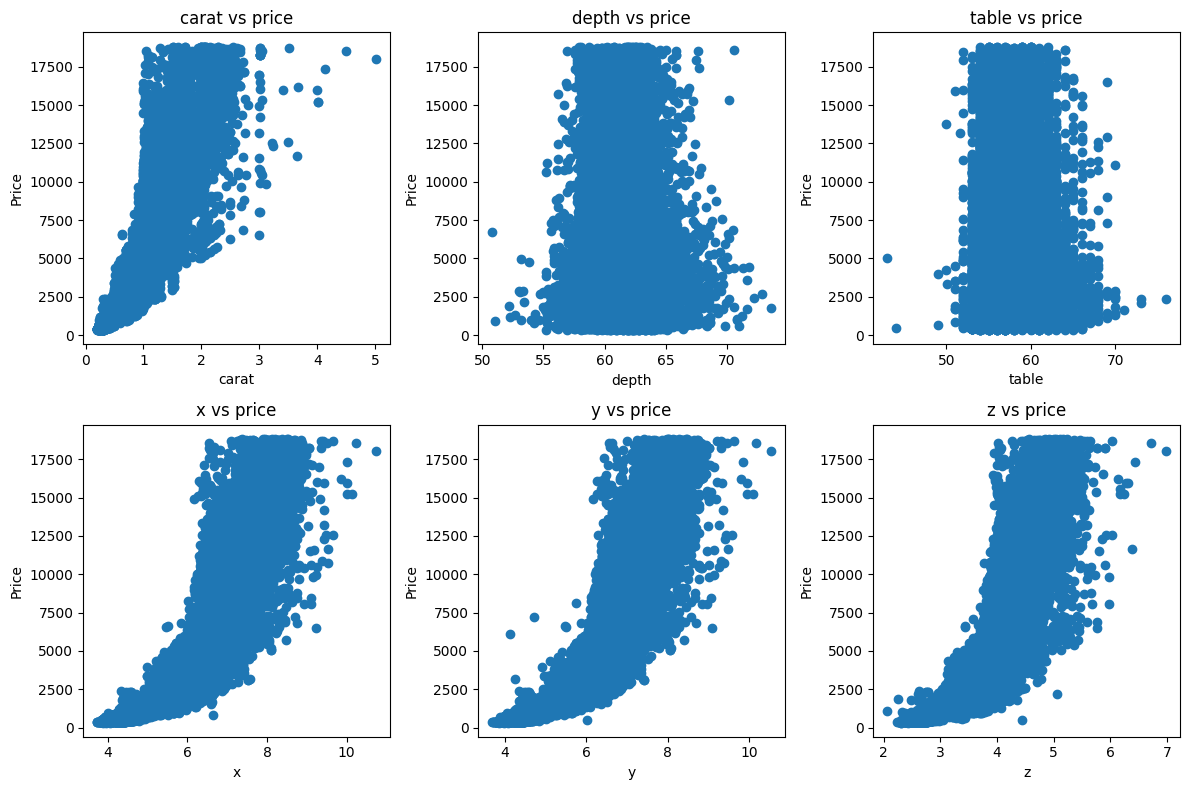

In [204]:
plot_statistics()

Under hela processen har vi bara förlorat 34 diamanter

In [205]:
print(f'{original_length - df.shape[0]} eller {round((original_length - df.shape[0]) / original_length, 4)}% av datapunkter borttagna')

34 eller 0.0006% av datapunkter borttagna


Det finns fortfarande några kolumner som har kategoriska värden (*cut*, *color*, *clarity*). Detta går inte att mata till modellen, så jag använder get_dummies för att konvertera till individuella kolumner liknande till en OneHotEncoder. Sedan tas kolumnerna med kategoriska värden bort

In [206]:
encoded_cut = pd.get_dummies(df['cut'], 'cut:', ' ')
encoded_color = pd.get_dummies(df['color'], 'color:', ' ')
encoded_clarity = pd.get_dummies(df['clarity'], 'clarity:', ' ')
df.drop(columns=['cut', 'color', 'clarity'], inplace=True)

df = pd.concat([encoded_cut, encoded_color, encoded_clarity, df], axis=1)

display(df.head())

,cut: Fair,cut: Good,cut: Ideal,cut: Premium,cut: Very Good,color: D,color: E,color: F,color: G,color: H,...,clarity: VS2,clarity: VVS1,clarity: VVS2,carat,depth,table,price,x,y,z
0,False,False,True,False,False,False,True,False,False,False,...,False,False,False,0.23,61.5,55.0,326,3.95,3.98,2.43
1,False,False,False,True,False,False,True,False,False,False,...,False,False,False,0.21,59.8,61.0,326,3.89,3.84,2.31
2,False,True,False,False,False,False,True,False,False,False,...,False,False,False,0.23,56.9,65.0,327,4.05,4.07,2.31
3,False,False,False,True,False,False,False,False,False,False,...,True,False,False,0.29,62.4,58.0,334,4.20,4.23,2.63
4,False,True,False,False,False,False,False,False,False,False,...,False,False,False,0.31,63.3,58.0,335,4.34,4.35,2.75


## 2. Skapa en modell
Först delas datan upp för träning och testning. Standardvärdet för delningen är 0.25, alltså blir 75% träning och 25% testning.

In [207]:
X = df.drop(columns='price')
y = df['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

Vi skapar den mest grundläggande versionen som går och testar hur bra den fungerar

In [208]:
params = {
    'random_state': 0
}

model = xgb.XGBRegressor(**params)
model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=0, ...)

Nu kan vi göra lite visualisering om hur bra den är

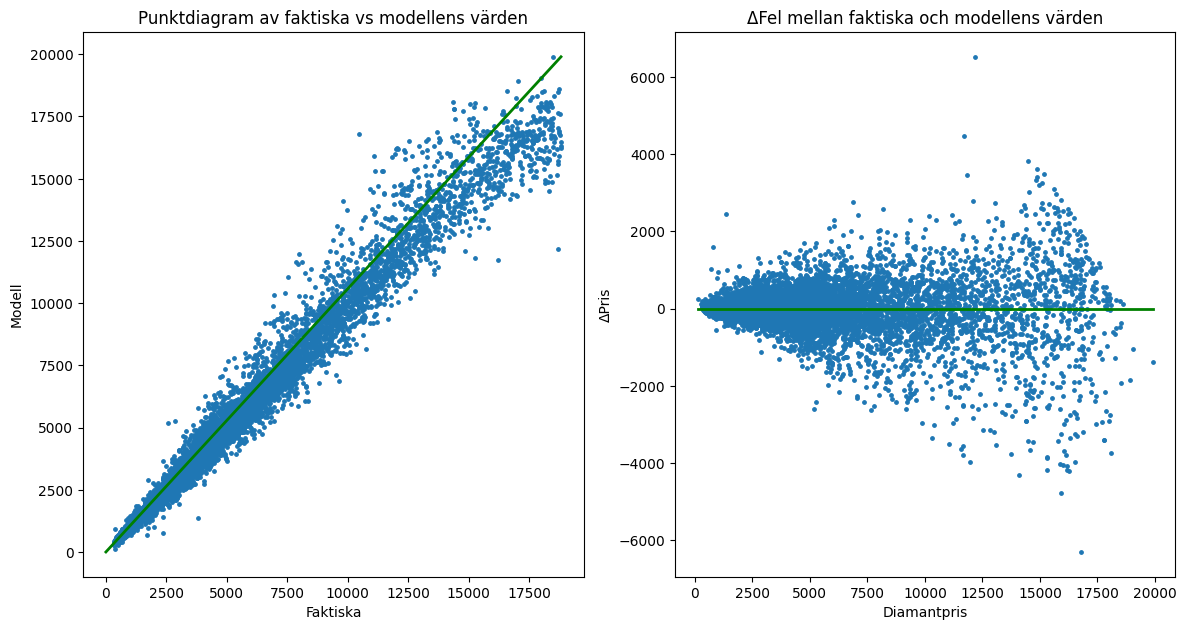

In [243]:
def plot_perf(model: xgb.XGBRegressor):
    '''Skapa en grafer som visar modellens'''
    
    y = model.predict(X_test)

    # plt.figure(figsize=(20, 20))

    y = model.predict(X_test)

    # Punktdiagram (faktiskt vs modell)
    plt.figure(figsize=(12, 12))
    plt.subplot(2, 2, 1)
    plt.scatter(y_test, y, s=6)
    plt.plot([0, max(y_test)], [0, max(y)], 'g', linewidth=2)
    plt.xlabel('Faktiska')
    plt.ylabel('Modell')
    plt.title('Punktdiagram av faktiska vs modellens värden')

    # # Punktdiagram (fel)
    plt.subplot(2, 2, 2)
    residuals = y_test - y
    plt.scatter(y, residuals, s=6)
    plt.plot([min(y), max(y)], [0, 0], 'g', linewidth=2)
    plt.xlabel('Diamantpris')
    plt.ylabel('ΔPris')
    plt.title('ΔFel mellan faktiska och modellens värden')

    plt.tight_layout()
    
plot_perf(model)